In [1]:
# Import packages
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Load donations.json

filename = "data/chrissie_donations.json"

with open(filename) as json_file: 
    donations = json.load(json_file)

# La thunasse ramassée au total

In [3]:
L = []
for videoid,videoobj in donations.items():
    amount = videoobj["resume"]["donations_total"]
    date = videoobj["resume"]["start_unix"]
    duration = videoobj["resume"]["duration_seconds"]
    L.append((date,amount,duration))
    
L.sort(key = lambda a : a[0])
thunasse_total = sum([item[1] for item in L])

print("la thunasse total ramassée sur", str(len(donations)), "vidéos est de : ", str(round(thunasse_total)), " €")

la thunasse total ramassée sur 22 vidéos est de :  6712  €


# Taux horaire

In [4]:
total_duration = sum([item[2] for item in L])
winrate = (3600*thunasse_total) / total_duration

print("Taux horaire : ",str(round(winrate,2)),"€ / h")

Taux horaire :  167.21 € / h


# La thunasse cumulée ramassée dans le temps

In [5]:
x = []
y = []
for item in L:
    x.append(item[0])
    y.append(item[1])
x = np.array(x)
y = np.array(y)

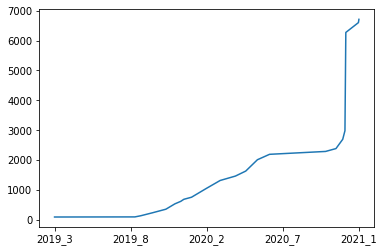

In [6]:
nthicks = 5
x_thicks = np.linspace(x[0],x[-1],nthicks)
x_thicks_labels = pd.to_datetime(x_thicks,unit="s")
x_thicks_labels = [str(item.year)+"_"+str(item.month) for item in x_thicks_labels]

plt.plot(x, np.cumsum(y))
plt.xticks(x_thicks, x_thicks_labels, rotation='horizontal')
plt.show()

### **Sympa le bump en mai 2020!**

# Evolution de la thunasse les 18 derniers mois

In [7]:
index = pd.to_datetime(x,unit="s")
series = pd.Series(y, index = index)
series.resample('M').sum().tail(18)

2019-08-31       0.000000
2019-09-30      41.984209
2019-10-31      98.644010
2019-11-30     120.897700
2019-12-31     331.674367
2020-01-31      69.661861
2020-02-29     293.348781
2020-03-31     268.208868
2020-04-30     147.394027
2020-05-31     167.818400
2020-06-30     561.609047
2020-07-31       0.000000
2020-08-31       0.000000
2020-09-30       0.000000
2020-10-31      96.433149
2020-11-30      96.069344
2020-12-31    3892.544651
2021-01-31     439.084829
Freq: M, dtype: float64

# Les donateurs

In [8]:
members = {}
for videoid, videoobj in donations.items():
    for msg in videoobj["messages"]:
        if "amount_euros" in msg:
            author = msg["author"]
            amount= msg["amount_euros"]
            members[author] = members.get(author,0) + amount
members = [(k,v) for k,v in members.items()]
members.sort(key=lambda a : -a[1])

In [9]:
print(len(members),"personnes ont fait au moins un don sur la chaîne")

419 personnes ont fait au moins un don sur la chaîne


# Les biggest donateurs

In [10]:
topk = 10
print("les plus",str(topk),"gros donateurs sont : ")
print("")
for m,v in members[:topk]:
    print(m,":",str(round(v)),"€")

les plus 10 gros donateurs sont : 

Who Cares : 333 €
Taeisbae : 322 €
Afro Basket : 219 €
The Pink Pill : 172 €
Tionna Toy : 172 €
eliyanora animalia : 107 €
Kay : 99 €
D : 88 €
Jordan Simone : 86 €
TINA D : 86 €


# Distribution des donateurs

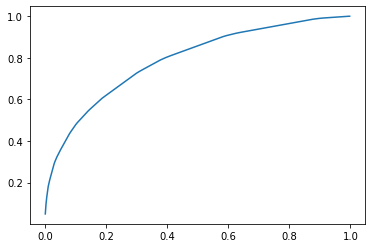

In [11]:
total_part = np.cumsum([item[1] for item in members]) / np.sum([item[1] for item in members])
members_part = np.array([i/len(total_part) for i in range(len(total_part))])
ndonateurs = np.argmin(np.abs(total_part - 0.5))
fifty_resp = round(members_part[np.argmin(np.abs(total_part - 0.5))] * 100,2)
eighty_resp = round(members_part[np.argmin(np.abs(total_part - 0.8))] * 100,2)
eighty_ndonateurs = np.argmin(np.abs(total_part - 0.8))

plt.plot(members_part, total_part)
plt.show()

In [12]:
print("La moitié du la thunasse des dons proviennent des",fifty_resp,"% top donateurs ( ~",str(ndonateurs+1),"donateurs )")

La moitié du la thunasse des dons proviennent des 11.22 % top donateurs ( ~ 48 donateurs )


## *Magnifique loi des 80/20*

In [13]:
print("80% de la thunasse des dons proviennent des",eighty_resp,"% top donateurs ( ~",str(eighty_ndonateurs+1),"donateurs )")

80% de la thunasse des dons proviennent des 39.38 % top donateurs ( ~ 166 donateurs )


# Les plus gros clickers
Non pas le volume d'argent mais le nombre de dons

In [14]:
class AutoVivification(dict):
    """Implementation of perl's autovivification feature."""
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value

In [17]:
members = AutoVivification()
for videoid, videoobj in donations.items():
    for msg in videoobj["messages"]:
        if "amount_euros" in msg:
            author = msg["author"]
            amount = msg["amount_euros"]
            members[author]["clicks"] = members[author].get("clicks",0) + 1
            members[author]["amount"] = members[author].get("amount",0) + amount

In [18]:
clickers = []
for name,obj in members.items():
    clickers.append((name,obj["clicks"]))
clickers.sort(key=lambda a : -a[1])

print("les 10 plus gros clickers :")
print("")
for m,c  in clickers[:10]:
    print(m,":",c,"dons")

les 10 plus gros clickers :

jay rae : 13 dons
Ti Said What Ti Said : 11 dons
CutieHoney13 : 11 dons
Stephanie J. Woodle : 10 dons
JOOCE NTWRK : 8 dons
Erika Kane : 8 dons
Mocha Mommy : 7 dons
Kay : 7 dons
Kereign : 7 dons
Queen : 6 dons


# Difference clickers vs donateurs

In [19]:
occurences = []
amount = []
for name, obj in members.items():
    occurences.append(obj["clicks"])
    amount.append(obj["amount"])
amount = np.array(amount)
occurences = np.array(occurences)

/home/loic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


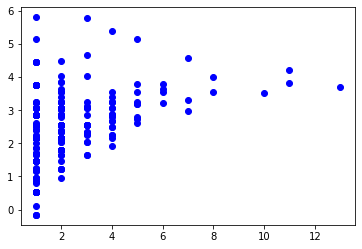

In [20]:
plt.plot(occurences, np.log(amount), 'o', color='blue')